In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import itertools as it
import time
import matplotlib.pyplot as plt
import graph_tools

# Eficiencia y Estabilidad

### Punto 1

#### Definición de funciones relevantes

In [2]:
# Función que permite crear las matrices de adyacencia a partir de listados de 0 y 1. 
def matrix_creator(lista,n):
    m = len(lista)
    if 2*m == (n*(n-1)):
        contador = 1
        A = []
        AA = [0 for i in range(n)]
        while contador < n+1:
            limite = n - contador
            B = lista[:limite]
            lista = lista[limite:]
            C = AA[:contador] + B
            A.append(C)
            contador+=1
        A = np.array(A)
        return A + np.transpose(A)
    else:
        print("Introduzca los inputs correctos")

# Funcion que permite crear todos los posibles vectores que representan una red no dirigida.
def network_creator(n):
    A = [0]*n
    B = [1]*n
    guardar = set()
    contador = 1
    while contador<n:
        C = B[:contador]+A[contador:]
        guardar = guardar.union(set(it.permutations(C,n)))
        contador+=1
    guardar = [list(i) for i in guardar]
    guardar = [A] + guardar + [B]
    return(guardar)

# Función que crea todas las matrices de adyacencia con n nodos
def all_adj_matrix_creator(n):
    longitud = int(((n-1)*n)/2)
    M_Adyacencia = [matrix_creator(i,n) for i in network_creator(longitud)]
    return M_Adyacencia

# Función que crea los grafos a partir de un listado de matrices de adyacencia
def all_graphs_creator(adj_matrix_list):
    Grafos = [nx.from_numpy_array(i) for i in adj_matrix_list]
    return Grafos

def isomorphism_identifier(graphs_list):
    Revisor = {i:True for i in range(len(graphs_list))}
    Clases_Equiv_Isomorfismos = []
    for i in Revisor:
        Clase = set([i])
        for j in Revisor:
            if j>i and Revisor[i] and Revisor[j] :
                if nx.is_isomorphic(graphs_list[i],graphs_list[j]):
                    Revisor[j] = False
                    Clase = Clase.union(set([j]))
        if Revisor[i]:
            Clases_Equiv_Isomorfismos.append(Clase)
    Grafos_Def = [graphs_list[list(i)[0]] for i in Clases_Equiv_Isomorfismos]
    return Grafos_Def,Clases_Equiv_Isomorfismos

#### Ejecución

In [3]:
# Creación inicial de las matrices de adyacencia y posterior a ello todos los grafos
n = 5
Grafos = all_graphs_creator(all_adj_matrix_creator(n))

In [4]:
# Obtención de los representantes de las clases de equivalencia de grafos isomorfos
Grafos_Def,Clases_Equiv_Isomorfismos = isomorphism_identifier(Grafos)

In [5]:
# Revisión de que todo esté correcto

# Grafos en las clases de equivalencia
print(sum([len(i) for i in Clases_Equiv_Isomorfismos]))
# Grafos definitivos
print(len(Grafos_Def))

1024
34


### Punto 2

#### Definición de funciones relevantes

In [6]:
# Función de utilidad que nos permite generar las utilidades relevantes
def utility_function(grafo,constante=0):
    utility = dict(grafo.degree())
    utility = {i:utility[i]-constante for i in utility}
    return utility

def utility_assign(Lista_Grafos,Constante):
    Utilidades = [utility_function(i,Constante) for i in Lista_Grafos]
    for i in range(len(Lista_Grafos)):
        nx.set_node_attributes(Lista_Grafos[i], Utilidades[i], "Utility") 

#### Ejecución

In [7]:
# Calculo de las utilidades para cada red (representes)
Constante = 1
utility_assign(Grafos_Def,Constante)


### Punto 3

#### Definición de funciones importantes

In [8]:
# Función que calcula la utilidad social de tipo utilitarista
def social_utility_generator(Lista_Grafos):
    Social_Utility = [sum(list(nx.get_node_attributes(Lista_Grafos[i],"Utility").values())) for i in range(len(Lista_Grafos))]
    return Social_Utility
# Función que identifica los grafos SE.
def max_social_utility_identifier(Lista_Grafos,Social_Utilities):
    Max_Social_Utility = max(Social_Utilities)
    Grafos_SE = [Lista_Grafos[i] for i in range(len(Social_Utilities)) if Social_Utilities[i] == Max_Social_Utility]
    return Grafos_SE



#### Ejecución

______________________________


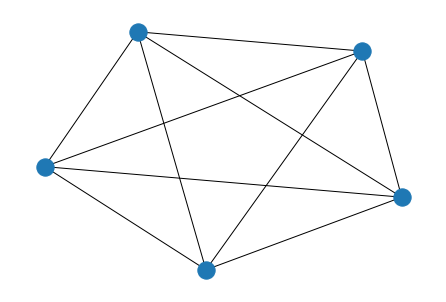

In [9]:
# Calculo de la utilidad social para las redes e identificación de los grafos SE
Social_Utility = social_utility_generator(Grafos_Def)
Grafos_SE = max_social_utility_identifier(Grafos_Def,Social_Utility)
for i in Grafos_SE:
    print("_"*30)
    nx.draw(i)

### Punto 4

#### Definición de funciones importantes

In [11]:
# Función que realiza la identificación de las clases pareto eficientes
def Revisor_Pareto(listado_representantes,listado_grafos,clases,constante):
    longitud = len(clases)
    Revisor = {i:True for i in range(longitud)}
    for i in range(longitud):
        grafo1 = listado_representantes[i]
        comparar1 = np.array(list(nx.get_node_attributes(grafo1,"Utility").values()))
        for j in range(longitud):
            if (i!=j):
                for k in clases[j]:
                    grafo2 = listado_grafos[k]
                    nx.set_node_attributes(grafo2,utility_function(grafo2,constante), "Utility")
                    comparar2 = np.array(list(nx.get_node_attributes(grafo2,"Utility").values()))
                    if any(comparar2>comparar1) & all(comparar2>=comparar1):
                        Revisor[i] = False
                        break
            if Revisor[i] == False:
                break
    return Revisor
# Función que dados unos identificadores de las clases pareto eficientes almacena los grafos PE
def Pareto_Identifier(listado_representantes,listado_pareto):
    Grafos_PE = [listado_representantes[i] for i in listado_pareto if listado_pareto[i]]
    return Grafos_PE

#### Ejecución

______________________________


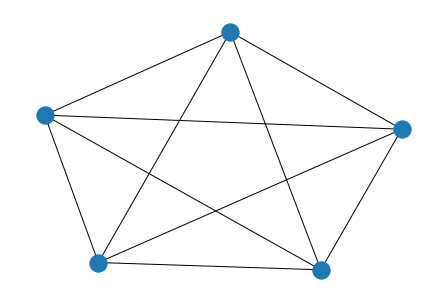

In [12]:
# Calculo de las clases PE e identificación de los representantes PE
Clases_Pareto_Eficientes = Revisor_Pareto(Grafos_Def,Grafos,Clases_Equiv_Isomorfismos,Constante)
Grafos_PE = Pareto_Identifier(Grafos_Def,Clases_Pareto_Eficientes)
for i in Grafos_PE:
   print("_"*30)
   nx.draw(i)

### Punto 5

#### Definición de funciones importantes

In [13]:
# Función que evalúa sobre un grafo si existe al menos un nodo que se beneficia de romper unilateralmente un enlace
def edge_evaluator_eliminate(grafo,constante):
    A = nx.to_numpy_matrix(grafo)
    n = A.shape[1]
    for i in range(n):
        for j in range(i+1,n):
            if A[i,j] == 1:
                AA = A.copy()
                AA[i,j] = 0
                AA[j,i] = 0
                grafo_ori = grafo.copy()
                grafo_mod = nx.from_numpy_array(AA)
                Grafos = [grafo_ori,grafo_mod]
                for gr in Grafos:
                    nx.set_node_attributes(gr,utility_function(gr,constante), "Utility")
                Utilidades = [list(nx.get_node_attributes(i,"Utility").values()) for i in Grafos]
                if (Utilidades[0][i]<Utilidades[1][i]) | (Utilidades[0][j]<Utilidades[1][j]):
                    return False
    return True
# Función que evalúa sobre un grafo si existe al menos un par de nodos que se benefician de crear bilateralmente un enlace
def edge_evaluator_add(grafo,constante):
    A = nx.to_numpy_matrix(grafo)
    n = A.shape[1]
    for i in range(n):
        for j in range(i+1,n):
            if A[i,j] == 0:
                AA = A.copy()
                AA[i,j] = 1
                AA[j,i] = 1
                grafo_ori = grafo.copy()
                grafo_mod = nx.from_numpy_array(AA)
                Grafos = [grafo_ori,grafo_mod]
                for gr in Grafos:
                    nx.set_node_attributes(gr,utility_function(gr,constante), "Utility")
                Utilidades = [list(nx.get_node_attributes(i,"Utility").values()) for i in Grafos]
                if (Utilidades[0][i]<Utilidades[1][i]) & (Utilidades[0][j]<Utilidades[1][j]):
                    return False
    return True
# Función que evalúa si un grafo es estable
def edge_evaluator(grafo,constante):
    if edge_evaluator_eliminate(grafo,constante) & edge_evaluator_add(grafo,constante):
        return True
    else:
        return False
# Función que arroja todos los grafos estables
def Stable_Identifier(lista_representantes,constante):
    Grafos_Stable = [i for i in lista_representantes if edge_evaluator(i,constante)]
    return Grafos_Stable


#### Ejecución

______________________________


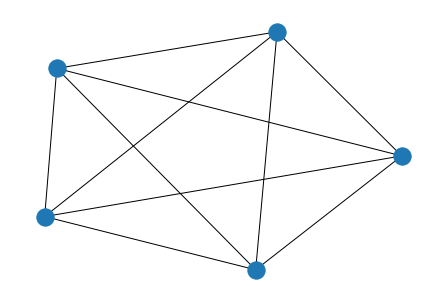

In [14]:
# Calculo de las clases Estables e identificación de los representantes de estas clases
Grafos_Stable = Stable_Identifier(Grafos_Def,Constante)
for i in Grafos_Stable:
   print("_"*30)
   nx.draw(i)

### Punto 6

#### Definición de funciones importantes

In [15]:
# Función que permite calcular los precios de estabilidad y anarquía
def precios(Listado_Grafos_SE,Listado_Grafos_Stable,indicador):
    U_Max = social_utility_generator(Grafos_Stable[0:1])[0]
    U_Stable = social_utility_generator(Listado_Grafos_Stable)
    if indicador == "Anarquia":
        US_Min = min(U_Stable)
        return U_Max/US_Min
    elif indicador == "Estabilidad":
        US_Max = max(U_Stable)
        return U_Max/US_Max
    else:
        return None

#### Ejecución

In [16]:
# Se encuentra el precio de estabilidad y anarquía
P_E = precios(Grafos_SE,Grafos_Stable,"Anarquia")
P_A = precios(Grafos_SE,Grafos_Stable,"Estabilidad")
# Se muestran los precios
print("Precio de Anarquía: {}".format(P_A))
print("Precio de Estabilidad: {}".format(P_E))
print("P_A<=P_E es {}".format(P_A<=P_E))

Precio de Anarquía: 1.0
Precio de Estabilidad: 1.0
P_A<=P_E es True


# Medidas sobre redes

In [2]:
# Bonanich
def Bonanich(grafo):
    matrix = nx.to_numpy_matrix(grafo)
    eigval,eigvec = np.linalg.eig(matrix)
    radius_pos = np.argmax(abs(eigval))
    return eigvec[:,radius_pos]

In [3]:
def HITS(grafo,metrica):
    matrix = nx.to_numpy_matrix(grafo)
    if metrica == 'HUBS':
        M = matrix@matrix.T 
    elif metrica == 'AUTH':
        M = matrix.T@matrix
    else:
        raise Exception('Introduzca Valores Correctos')
    eigval,eigvec = np.linalg.eig(M)
    radius_pos = np.argmax(abs(eigval))
    return eigvec[:,radius_pos]

    

# Producción